In [143]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd

import seaborn as sb
plt.style.use("dark_background")

### Space launches data

I've found a great dataset about space launches from 1967 until nowdays. It has some interesting properties such as state of incorporation of the company, which organized the launch, and it's eqity type. I want to explore how space launches market had evolved through time. Also, it's interesting to see how big is SapceX right now comapred to other companies.

In [144]:
launches = pd.read_csv('./launches.csv')
launches = launches[['launch_year', 'state_code', 'agency_type', 'type']]
launches.head()

,launch_year,state_code,agency_type,type
0,1967,US,state,Thor Burner 2
1,1967,US,state,Thor Burner 2
2,1967,US,state,Thor Burner 2
3,1968,US,state,Thor Burner 2
4,1968,US,state,Thor Burner 2


In [145]:
# mapper for countries
def countries(x):
    mapper = {
        'CN': 'China',
        'RU': 'Russia',
        'US': 'USA',
        'SU': 'USSR',
        'UK': 'EU',
        'F': 'EU',
        'BR': 'EU',
        'I': 'EU',
        'I-ELDO': 'EU',
        'I-ESA': 'EU',
    }
    try:
        return mapper[x]
    except:
        return 'Other'

# mapper for company type
def agencies(x):
    mapper = {
        'private': 'Private',
        'state': 'State',
        'startup': 'Startup'
    }
    
    return mapper[x]

# mapper for rocket names
def rockets(x):
    mapper = {
        'Falcon 1': 'SpaceX',
        'Falcon 9': 'SpaceX',
        'Falcon Heavy': 'SpaceX'
    }
    
    try:
        return mapper[x]
    except:
        return 'Other USA'

# apply mappers and filter countries
launches['state_code'] = launches['state_code'].apply(lambda x: countries(x))
launches['agency_type'] = launches['agency_type'].apply(lambda x: agencies(x))
launches = launches.dropna()

### Stacked barplot class

Seaborn doesn't provide support for stacked barplot out of the box. But luckily, I found great implementation of this feature on the [GitHub](https://github.com/mwaskom/seaborn/issues/1485).

In [146]:
from __future__ import division
from textwrap import dedent
import colorsys
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.patches as Patches
import matplotlib.pyplot as plt
import warnings
from six import string_types
from six.moves import range
 
from seaborn import utils
from seaborn.axisgrid import FacetGrid
from seaborn.categorical import _BarPlotter, _CategoricalPlotter
from seaborn.categorical import factorplot as _factorplot
 
__all__ = ['countplot', 'factorplot', 'freqplot']
 
class _StackBarPlotter(_BarPlotter):
    """ Stacked Bar Plotter
 
    A modification of the :mod:`seaborn._BarPlotter` object with the added ability of
    stacking bars either verticaly or horizontally. It takes the same arguments
    as :mod:`seaborn._BarPlotter` plus the following:
 
    Arguments
    ---------
    stack : bool
        Stack bars if true, otherwise returns equivalent barplot as
        :mod:`seaborn._BarPlotter`.
    """
    def draw_bars(self, ax, kws):
        """Draw the bars onto `ax`."""
        # Get the right matplotlib function depending on the orientation
        barfunc = ax.bar if self.orient == "v" else ax.barh
        barpos = np.arange(len(self.statistic))
        
        if self.plot_hues is None:
            
            # Draw the bars
            barfunc(barpos, self.statistic, self.width,
                    color=self.colors, align="center", 
                    **kws)

            # Draw the confidence intervals
            errcolors = [self.errcolor] * len(barpos)
            self.draw_confints(ax,
                            barpos,
                            self.confint,
                            errcolors,
                            self.errwidth,
                            self.capsize)
        else:
            # Stack by hue
            for j, hue_level in enumerate(self.hue_names):

                barpos_prior = None if j == 0 else np.sum(self.statistic[:, :j], axis=1)

                # Draw the bars
                if self.orient == "v":
                    barfunc(barpos, self.statistic[:, j], self.nested_width,
                            bottom=barpos_prior, color=self.colors[j], align="center",
                            label=hue_level, **kws)
                elif self.orient == "h":
                    barfunc(barpos, self.statistic[:, j], self.nested_width,
                            left=barpos_prior, color=self.colors[j], align="center",
                            label=hue_level, **kws)

                # Draw the confidence intervals
                if self.confint.size:
                    confint = self.confint[:, j] if j == 0 else np.sum(self.confint[:, :j], axis=1)
                    errcolors = [self.errcolor] * len(barpos)
                    self.draw_confints(ax,
                                    barpos,
                                    confint,
                                    errcolors,
                                    self.errwidth,
                                    self.capsize)
                    

def countplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
             orient=None, color=None, palette=None, saturation=.75,
             dodge=True, stack=False, ax=None, **kwargs):
    """ Show the count of observations in each categorical bin using bars.
 
    The count plot is a normalization of a histogram across categories, as opposed
    to quantitative variables. The basic API and options are identical to those for
    :func:`barplot`, so you can compare counts across nested variables.
 
    Parameters
    ----------
    x, y, hue : str or array-like, optional
        Inputs for plotting long-form data.
    data : DataFrame, array, or list of arrays, optional
        Dataset for plotting. If `x` and `y` are absent, this is interpreted as wide-form.
        Otherwise, data is expected to be long-form.
    order, hue_order : list of str, optional
        Order to plot the categorical levels, otherwise the levels are inferred from the
        data object.
    orient : {"v", "h"}, optional
        Whether to plot bars vertically ("v") or horizontally ("h"). This can also be
        inferred from the dtype of the input variables, but can be used to specify when the
        "categorical" variable is a numeric or when plotting wide-form data.
    color : matplotlib color, optional
        Color for all of the elemnts, or seed for a gradient palette.
    palette : palette name, list, or dict, optional
        Colors to use for the different levels of the `hue` variable. Should be somthing that
        can be interpreted by `color_palette()` or a dictionary mapping hue levels to
        matplotlib colors.
    saturation :  float, optional
        Proportion of the original saturation to draw colors. Large patches often look better
        with slighlty desaturated colors, but set this to `1` if you want the plot colorss to
        perfectly match the input color spec.
    dodge : bool, optional
        When hue nesting is used, whether elements should be shifted along the categorical axis.
    stack : bool, optional
        When hue nesting is used, whether elements should be stacked ontop of each other. Note,
        dodge is set to False when stack is True.
    ax : matplotlib.axes, optional
        Axes object to draw the plot onto, otherwise uses the current axes.
    **kwargs : Other keyword arguments are passed through to `plt.bar` at draw time
 
    Examples
    --------
    .. plot::
        :context: close-figs
 
        >>> import schmeaborn as sns
        >>> titanic = sns.load_dataset("titanic")
        >>> ax = sns.freqplot(x="class", data=titanic)
 
    Show frequencies for two categorical variables:
 
    .. plot::
        :context: close-figs
 
        >>> ax = sns.freqplot(x="class", hue="who", data=titanic)
 
    Plot the bars horizontally:
 
    .. plot::
        :context: close-figs
 
        >>> ax = sns.freqplot(y="class", hue="who", data=titanic)
 
    Plot categories stacked:
 
    .. plot::
        :context: close-figs
 
        >>> ax = sns.freqplot(x="class", hue="who", stack=True, data=titanic)
    """
    
    # Define parameters for barplot
    if stack:
        dodge = False
    estimator = len
    ci = None
    n_boot = 0
    units = None
    errcolor = None
    errwidth = None
    capsize = None

    # Check orientation by input
    if x is None and y is not None:
        orient = "h"
        x = y
    elif y is None and x is not None:
        orient = "v"
        y = x
    elif x is not None and y is not None:
        raise TypeError("Cannot pass values for both `x` and `y`")
    else:
        raise TypeError("Must pass values for either `x` or `y`")

    bar_plot_func = _StackBarPlotter if stack else _BarPlotter
    plotter = bar_plot_func(x, y, hue, data, order, hue_order,
                            estimator, ci, n_boot, units,
                            orient, color, palette, saturation,
                            errcolor, errwidth, capsize, dodge)

    plotter.value_label = "count"

    if ax is None:
        ax = plt.gca()

    plotter.plot(ax, kwargs)
    return ax


def freqplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
             orient=None, color=None, palette=None, saturation=.75,
             dodge=True, stack=False, ax=None, **kwargs):
    """ Show the frequency of observations in each categorical bin using bars.
 
    The frequency plot is a normalization of a histogram across categories, as opposed
    to quantitative variables. The basic API and options are identical to those for
    :func:`barplot`, so you can compare counts across nested variables.
 
    Parameters
    ----------
    x, y, hue : str or array-like, optional
        Inputs for plotting long-form data.
    data : DataFrame, array, or list of arrays, optional
        Dataset for plotting. If `x` and `y` are absent, this is interpreted as wide-form.
        Otherwise, data is expected to be long-form.
    order, hue_order : list of str, optional
        Order to plot the categorical levels, otherwise the levels are inferred from the
        data object.
    orient : {"v", "h"}, optional
        Whether to plot bars vertically ("v") or horizontally ("h"). This can also be
        inferred from the dtype of the input variables, but can be used to specify when the
        "categorical" variable is a numeric or when plotting wide-form data.
    color : matplotlib color, optional
        Color for all of the elemnts, or seed for a gradient palette.
    palette : palette name, list, or dict, optional
        Colors to use for the different levels of the `hue` variable. Should be somthing that
        can be interpreted by `color_palette()` or a dictionary mapping hue levels to
        matplotlib colors.
    saturation :  float, optional
        Proportion of the original saturation to draw colors. Large patches often look better
        with slighlty desaturated colors, but set this to `1` if you want the plot colorss to
        perfectly match the input color spec.
    dodge : bool, optional
        When hue nesting is used, whether elements should be shifted along the categorical axis.
    stack : bool, optional
        When hue nesting is used, whether elements should be stacked ontop of each other. Note,
        dodge is set to False when stack is True.
    ax : matplotlib.axes, optional
        Axes object to draw the plot onto, otherwise uses the current axes.
    **kwargs : Other keyword arguments are passed through to `plt.bar` at draw time
 
    Examples
    --------
    .. plot::
        :context: close-figs
 
        >>> import schmeaborn as sns
        >>> titanic = sns.load_dataset("titanic")
        >>> ax = sns.freqplot(x="class", data=titanic)
 
    Show frequencies for two categorical variables:
 
    .. plot::
        :context: close-figs
 
        >>> ax = sns.freqplot(x="class", hue="who", data=titanic)
 
    Plot the bars horizontally:
 
    .. plot::
        :context: close-figs
 
        >>> ax = sns.freqplot(y="class", hue="who", data=titanic)
 
    Plot categories stacked:
 
    .. plot::
        :context: close-figs
 
        >>> ax = sns.freqplot(x="class", hue="who", stack=True, data=titanic)
    """ 

    # Define parameters for barplot
    if stack:
        dodge = False
    estimator = len
    ci = None
    n_boot = 0
    units = None
    errcolor = None
    errwidth = None
    capsize = None

    # Check orientation by input
    if x is None and y is not None:
        orient = "h"
        x = y
    elif y is None and x is not None:
        orient = "v"
        y = x
    elif x is not None and y is not None:
        raise TypeError("Cannot pass values for both `x` and `y`")
    else:
        raise TypeError("Must pass values for either `x` or `y`")

    bar_plot_func = _StackBarPlotter if stack else _BarPlotter
    plotter = bar_plot_func(x, y, hue, data, order, hue_order,
                            estimator, ci, n_boot, units,
                            orient, color, palette, saturation,
                            errcolor, errwidth, capsize, dodge)
    
    # Safely calculate frequencies: NaN counts replaced by 0
    plotter.statistic = np.nan_to_num(plotter.statistic)
    
    if plotter.statistic.ndim == 1:
        # Normalize statistic
        plotter.statistic = plotter.statistic / np.nansum(plotter.statistic)

        # Safety Check for proper normalization
        err = f"Frequencies not properly normalized. \n {plotter.statistic} \n"
        assert np.allclose(np.nansum(plotter.statistic), 1, rtol=1e-6), err
    elif plotter.statistic.ndim > 1:
        # Normalize row-stochastic
        plotter.statistic = plotter.statistic / np.nansum(plotter.statistic, axis=1)[:, None]

        # Safely check for proper normalization (ignore where full row is null)
        sum_stats = np.nansum(plotter.statistic, axis=1)

        # Safety Check for proper normalization
        err = f"Frequencies not properly normalized. \n {plotter.statistic} \n"
        assert np.allclose(sum_stats, 1, rtol=1e-6), err
    else:
        raise ValueError("Unable to count the combination of x and hue.")

    plotter.value_label = "frequency"

    if ax is None:
        ax = plt.gca()

    plotter.plot(ax, kwargs)
    return ax

### Finally, visualization

I didn't want to create any complicated visulizations, because for me it was more important to show the evolution of the market and SpaceX's place in it. So the final visualization consists from four plots:
* Share of each "space" country in the global market
* Structure of ownership in the global market
* Share of private equity companies by country
* SapceX growth and it's share in the US market

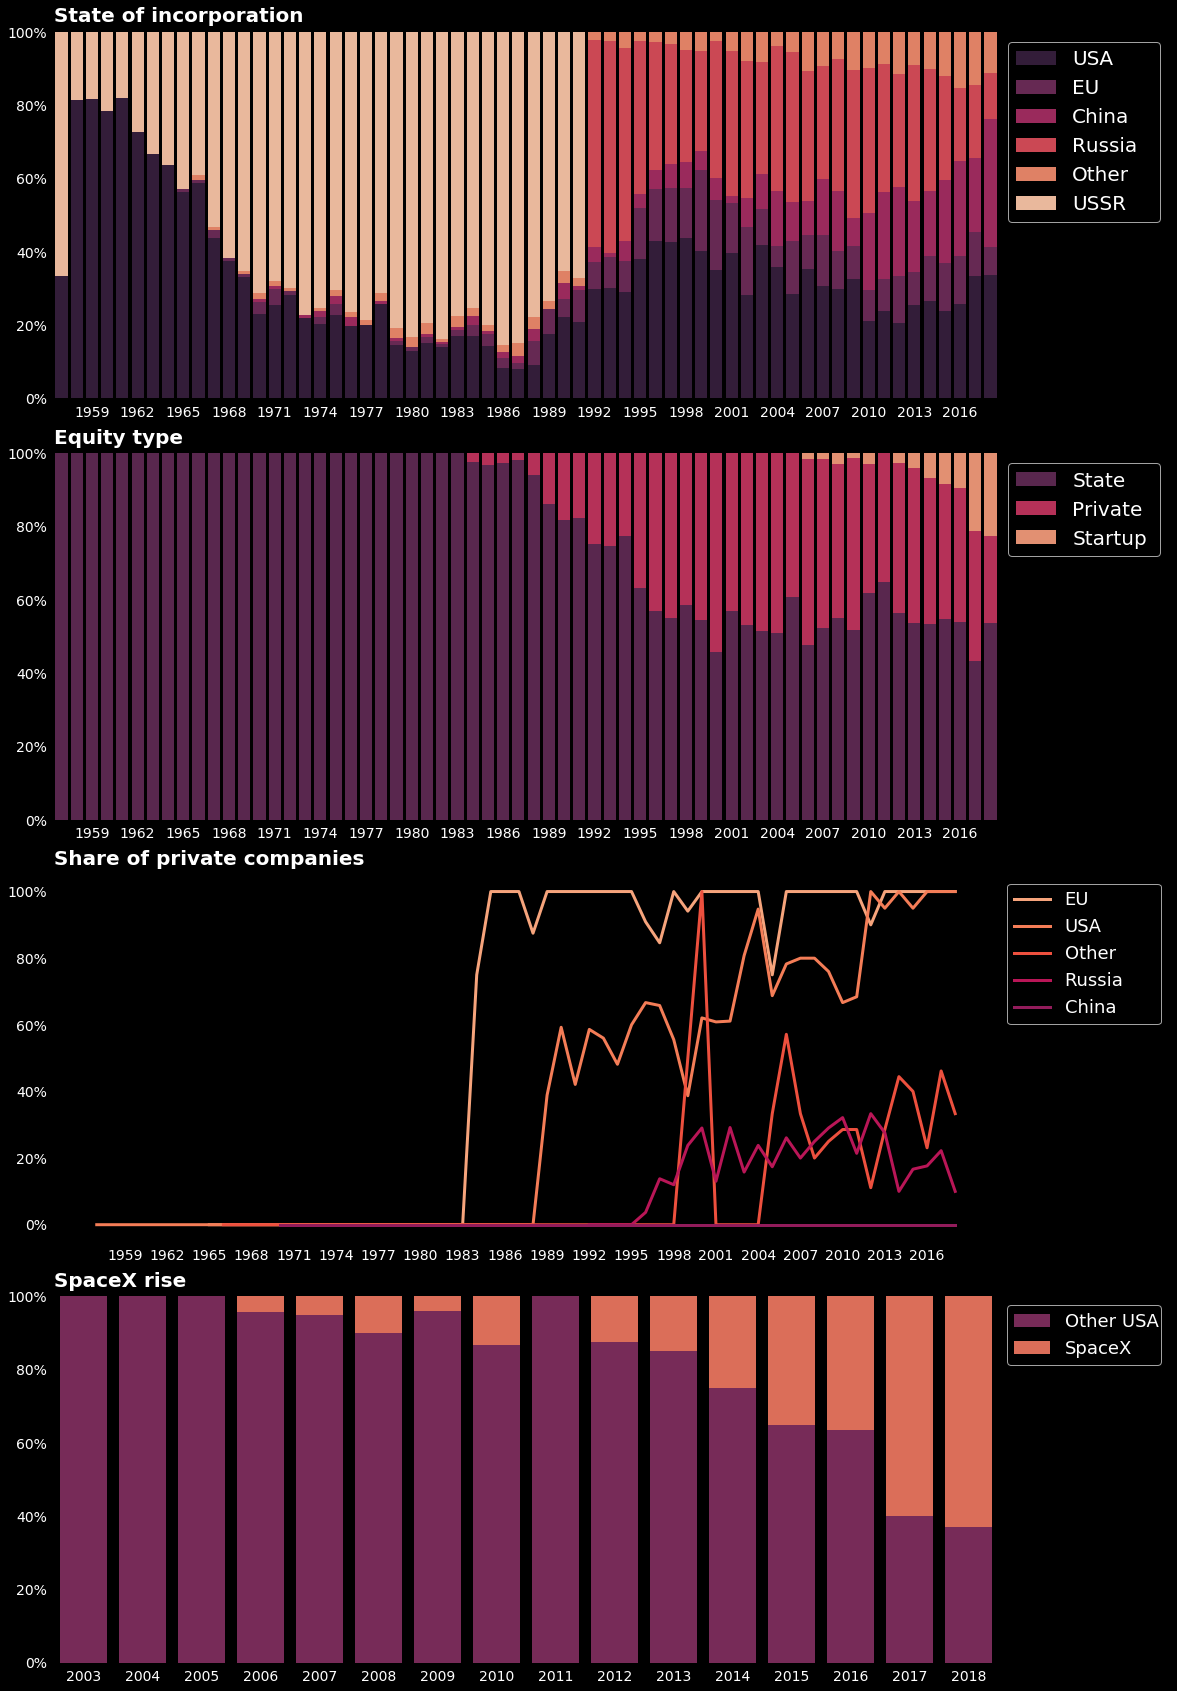

In [159]:
fig = plt.figure(figsize=(20, 30))

gs = grd.GridSpec(4, 2, height_ratios=[0.6, 0.6, 0.6, 0.6], width_ratios=[11, 2], hspace=0.15, wspace=0)

ax1 = plt.subplot(gs[1, 0])
freqplot(x='launch_year', hue='agency_type', data=launches, stack=True, palette='rocket', linewidth=0, ax=ax1)

_ = ax1.legend()
_ = ax1.set_xlabel('')
_ = ax1.set_ylabel('')
_ = ax1.set_title('Equity type', loc='left', fontdict={'size': 20, 'weight': 'bold'}, pad=10.)

years = np.sort(launches.launch_year.unique())
xticks = np.arange(2, years.shape[0], 3)
_ = ax1.set_xticks(xticks)
_ = ax1.set_xticklabels(years[xticks], rotation='horizontal', fontdict={'size': 14})
vals = ax1.get_yticks()
vals = ['{:.0%}'.format(x) for x in vals]
ax1.set_yticklabels(vals, fontdict={'size': 14})
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.grid(False)
ax1.tick_params(bottom=False, left=False)

ax2 = plt.subplot(gs[0, 0])
launches = launches[launches['state_code'].isin(['USA', 'EU', 'USSR', 'Russia', 'China', 'Other'])]
freqplot(x='launch_year', hue='state_code', data=launches, stack=True, palette='rocket', linewidth=0, ax=ax2)

_ = ax2.legend()
_ = ax2.set_xlabel('')
_ = ax2.set_ylabel('')
_ = ax2.set_title('State of incorporation', loc='left', fontdict={'size': 20, 'weight': 'bold'}, pad=10.)

years = np.sort(launches.launch_year.unique())
xticks = np.arange(2, years.shape[0], 3)
_ = ax2.set_xticks(xticks)
xticklabels = years[xticks]
_ = ax2.set_xticklabels(xticklabels, rotation='horizontal', fontdict={'size': 14})
vals = ax2.get_yticks()
vals = ['{:.0%}'.format(x) for x in vals]
ax2.set_yticklabels(vals, fontdict={'size': 14})
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.grid(False)
ax2.tick_params(bottom=False, left=False)

ax3 = plt.subplot(gs[1, 1])
handles, labels = ax1.get_legend_handles_labels()
_ = ax3.legend(handles, labels, loc='upper center', mode='expand', prop={'size': 20})
_ = ax3.grid('off')
_ = ax3.axis('off')

ax4 = plt.subplot(gs[0, 1])
handles, labels = ax2.get_legend_handles_labels()
_ = ax4.legend(handles, labels, loc='upper center', mode='expand', prop={'size': 20})
_ = ax4.grid('off')
_ = ax4.axis('off')

ax7 = plt.subplot(gs[2, 0])
usa_launches = launches[launches.state_code == 'USA'].groupby(['launch_year', 'agency_type'], as_index=False).count()
usa_launches = usa_launches.pivot(index='launch_year', columns='agency_type', values='type')
usa_launches = usa_launches.fillna(0)
usa_launches = usa_launches.reset_index()
usa_launches['div'] = (usa_launches['Private'] + usa_launches['Startup']) / (usa_launches['State'] + usa_launches['Private'] + usa_launches['Startup'])

china_launches = launches[launches.state_code == 'China'].groupby(['launch_year', 'agency_type'], as_index=False).count()
china_launches = china_launches.pivot(index='launch_year', columns='agency_type', values='type')
china_launches = china_launches.fillna(0)
china_launches = china_launches.reset_index()
china_launches['div'] = 1 - (china_launches['State']) / (china_launches['State'])

eu_launches = launches[launches.state_code == 'EU'].groupby(['launch_year', 'agency_type'], as_index=False).count()
eu_launches = eu_launches.pivot(index='launch_year', columns='agency_type', values='type')
eu_launches = eu_launches.fillna(0)
eu_launches = eu_launches.reset_index()
eu_launches['div'] = (eu_launches['Private']) / (eu_launches['State'] + eu_launches['Private'])

ru_launches = launches[launches.state_code == 'Russia'].groupby(['launch_year', 'agency_type'], as_index=False).count()
ru_launches = ru_launches.pivot(index='launch_year', columns='agency_type', values='type')
ru_launches = ru_launches.fillna(0)
ru_launches = ru_launches.reset_index()
ru_launches['div'] = (ru_launches['Private']) / (ru_launches['State'] + ru_launches['Private'])

other_launches = launches[launches.state_code == 'Other'].groupby(['launch_year', 'agency_type'], as_index=False).count()
other_launches = other_launches.pivot(index='launch_year', columns='agency_type', values='type')
other_launches = other_launches.fillna(0)
other_launches = other_launches.reset_index()
other_launches['div'] = (other_launches['Private']) / (other_launches['State'] + other_launches['Private'])

colors = sb.palettes.color_palette('rocket', 10)
_ = sb.lineplot(x='launch_year', y='div', data=eu_launches, label='EU', 
                linewidth=3., color=colors[-2], ax=ax7)
_ = sb.lineplot(x='launch_year', y='div', data=usa_launches, label='USA', 
                linewidth=3., color=colors[-3], ax=ax7)
_ = sb.lineplot(x='launch_year', y='div', data=other_launches, label='Other', 
                linewidth=3., color=colors[-4], ax=ax7)
_ = sb.lineplot(x='launch_year', y='div', data=ru_launches, label='Russia', 
                linewidth=3., color=colors[4], ax=ax7)
_ = sb.lineplot(x='launch_year', y='div', data=china_launches, label='China', 
                linewidth=3., color=colors[3], ax=ax7)

_ = ax7.legend()
_ = ax7.set_xlabel('')
_ = ax7.set_ylabel('')
_ = ax7.set_title('Share of private companies', loc='left', fontdict={'size': 20, 'weight': 'bold'}, pad=10.)

years = np.sort(launches.launch_year.unique())
xticks = np.arange(2, years.shape[0], 3)
_ = ax7.set_xticks(years[xticks])
xticklabels = years[xticks]
_ = ax7.set_xticklabels(xticklabels, rotation='horizontal', fontdict={'size': 14})
vals = ax7.get_yticks()
vals = ['{:.0%}'.format(x) for x in vals]
ax7.set_yticklabels(vals, fontdict={'size': 14})
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)
ax7.spines['left'].set_visible(False)
ax7.spines['bottom'].set_visible(False)
ax7.grid(False)
ax7.tick_params(bottom=False, left=False)

ax8 = plt.subplot(gs[2, 1])
handles, labels = ax7.get_legend_handles_labels()
_ = ax8.legend(handles, labels, loc='upper center', mode='expand', prop={'size': 18})
_ = ax8.grid('off')
_ = ax8.axis('off')

ax5 = plt.subplot(gs[3, 0])

spacex_launches = launches[launches.launch_year.isin(np.arange(2003, 2019, 1))].copy()
spacex_launches['type'] = spacex_launches['type'].apply(lambda x: rockets(x))
spacex_launches = spacex_launches[spacex_launches.state_code.isin(['USA'])]
freqplot(x='launch_year', hue='type', data=spacex_launches, stack=True, palette='rocket', linewidth=0, ax=ax5)

_ = ax5.set_xlabel('')
_ = ax5.set_ylabel('')
_ = ax5.set_title('SpaceX rise', loc='left', fontdict={'size': 20, 'weight': 'bold'}, pad=10.)

years = np.sort(spacex_launches.launch_year.unique())
xticks = np.arange(0, years.shape[0], 1)
_ = ax5.set_xticks(xticks)
xticklabels = years[xticks]
_ = ax5.set_xticklabels(xticklabels, rotation='horizontal', fontdict={'size': 14})
vals = ax5.get_yticks()
vals = ['{:.0%}'.format(x) for x in vals]
ax5.set_yticklabels(vals, fontdict={'size': 14})
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.grid(False)
ax5.tick_params(bottom=False, left=False)

ax6 = plt.subplot(gs[3, 1])
handles, labels = ax5.get_legend_handles_labels()
_ = ax6.legend(handles, labels, loc='upper center', mode='expand', prop={'size': 18})
_ = ax6.grid('off')
_ = ax6.axis('off')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax5.get_legend().remove()
ax7.get_legend().remove()



I want to draw a few conclusions based on those visualizations:
* USA is a constant dominant player in the market. Especially, they gained a big sahre after USSR colapse in 1991. But in a recent years they are threatened by Chinese rising space industry.
* In 80-90s there were a rise of private space companies. And main drivers of such shift are EU and USA.
* SpaceX became one of the biggest players in the USA and global market. Now SpaceX is a driver of the private sector in space industry.